# Code to take data using the scope and plot relevant histograms. Will output energy resolution and associated errors.

In [1]:
import os
import sys
import pyvisa as visa
from datetime import datetime

import importlib
import h5py # This is the python library that creates files/stores data sets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

#Local scripts
import MSO4102Bastro as sdaq # This is the scope module that Sean G. wrote. You will need this module (should be on GitHub, https://github.com/ibrewer/scope-daq)
import readData

### Enter the IP address of the scope as a string. The IP address of the scope should be set by the router (make sure both the scope and the lab laptop are plugged into the router). To check the IP address of the scope, you can go to the Utility menu and check the LAN settings. Sometimes a LAN reset is required.

Define output file and data set names

In [2]:
AMP=1

source="notReallyASource"
additionalName = "test1"

dsName='run8'

triggerThreshold_inj=100
triggerThreshold_source=20 #mV

traces=100
minutes=2

outName=f"{additionalName}_{source}_{minutes}min"

savePlots=True 
testTrigger=False

current_time = datetime.now()
today = current_time.strftime('%m%d%y')
path=f'../dataOut/{today}_amp{AMP}/'
if not os.path.exists(path):
    os.makedirs(path)
    
offSets = [538, 600, 0, 0] #scope offsets in mV

In [3]:
scope = sdaq.Scope(address="169.254.2.185")
scope.set_source_channel(AMP)
scope.get_source_channel(True)

#injection run: Triggering on channel 3, 100 mV 
if "inj" in source:
    scope.set_trigger(3, triggerThreshold_inj, edge="FALL") 
#source run
else:
    threshold = offSets[AMP-1] + triggerThreshold_source
    print(threshold)
    scope.set_trigger(AMP, threshold, edge="RIS")

trigger_dict = scope.get_trigger_config()
print(trigger_dict)
scaling_dict = scope.read_scaling_config()


Data source channel: 1
548
{'EDGE:SOURCE': 'CH1', 'EDGE:SLOPE': 'RIS', 'LEVEL': '548.0000E-3'}


In [4]:
trigger_dict = scope.get_trigger_config()
print(trigger_dict)

{'EDGE:SOURCE': 'CH1', 'EDGE:SLOPE': 'RIS', 'LEVEL': '548.0000E-3'}


In [5]:
f = h5py.File(path+outName+'.h5py', 'a')

In [6]:
#test trigger settins
if testTrigger:
    
    readData.get_data(f, scope, 1, dsName+"_triggerTest", 1, overwrite=True, useTraceLimit=True) # take data
    
    plot_array = f[dsName+"_triggerTest"] # insert desired data set name here
    time_axis = np.array(f[dsName+"_triggerTest_t"])
    baseline = f[dsName + "_triggerTest_baseline"]
    
    plt.plot(time_axis*1e6, plot_array[0])
    plt.axhline(float(trigger_dict["LEVEL"])-float(baseline[0]), color="r", ls="--")
    
    #clean up
    for name in ["", "+t", "_peaks", "_integral", "_baseline", "_peakTime"]: 
        if (dsName + "_triggerTest" + name) in f:
            del f[dsName + "_triggerTest"  + name]
    raise SystemExit("check trigger settings!")
    

### This command creates a h5py file, desginated as "f." Documentation for h5py can be found at http://docs.h5py.org/en/stable/. 
### NOTE: Please keep the 'a' flag.  ***Also, make sure you close an open file (use f.close()) before you open a new one.***

In [7]:
trigger_data = []
for key, value in trigger_dict.items():
    trigger_data.append([key, value])
f.create_dataset(dsName+"_triggerSettings", data=trigger_data)

<HDF5 dataset "run8_triggerSettings": shape (3, 2), type "|O">

### Create an array that stores the scope scaling dictionary. This will make sure that we have the scope settings for any given run.

### If you want to extract the scope scaling parameters from a file, the 5 settings are stored in the order [x zero, x incr, y zero, y mult, y offset].
### To extract the data, you could say ***data_scale = f['scope_scaling']*** and then extract the values that you want using ***data_scale[1] = x_increment***, for example.

In [8]:
scaling_info = np.zeros(5)
scaling_info[0] = float(scaling_dict['XZERO'])
scaling_info[1] = float(scaling_dict['XINCR'])
scaling_info[2] = float(scaling_dict['YZERO'])
scaling_info[3] = float(scaling_dict['YMULT'])
scaling_info[4] = float(scaling_dict['YOFF'])

dset = f.create_dataset(dsName+'_scaling', data=scaling_info)

### Meta-data storing dictionary
Some things you will want to update depending on your run

In [9]:
metadata = []
metadata.append(['trigger [mV]','50'])
metadata.append(['bias voltage [V]','60']) #from HV power supply
metadata.append(['blres','5'])
metadata.append(['vn1','4'])
metadata.append(['vnfb','1']) #gain
metadata.append(['vnfoll','1'])
metadata.append(['vn2','0'])
metadata.append(['vnfoll2','5'])
metadata.append(['vnbias','5'])
metadata.append(['vpload','2'])
metadata.append(['vncomp','0']) #should always be 0
#for dark runs
metadata.append(['dark','N'])

f.create_dataset(dsName+'_metaData',data=metadata)

<HDF5 dataset "run8_metaData": shape (12, 2), type "|O">

### Actually take data. Function inputs:
1) Length of run [minutes]

2) Name of dataset saved

3) Number of full traces saved (optional)

4) Noise range of points on trace (optional)

5) Signal range of points on scope (optional)

In [10]:
readData.get_data(f,scope, minutes, dsName, traces) # take data

Starting 2 minute run; will be done at Tue, 02 Nov 2021 15:25:07
Recorded 516 traces in 2.002 minutes. Average rate: 4.30 Hz


In [11]:
#alert when run is finished
sound_file = './beep-09.wav'
Audio(sound_file, autoplay=True)

### List the data sets within a file (check to make sure your run is there):

In [12]:
list(f.keys())

['run8',
 'run8_baseline',
 'run8_integral',
 'run8_metaData',
 'run8_peakTime',
 'run8_peaks',
 'run8_scaling',
 'run8_t',
 'run8_triggerSettings',
 'run8_triggerTest_t']

### Data analysis/plotting: assign the data set as the array "plot_array."

In [13]:
plot_array = f[dsName] # insert desired data set name here
time_axis = np.array(f[dsName+"_t"])
#sanity check
if len(plot_array)!=traces: 
    print("ERROR - SOMETHING AWRY \n dataset length is not what was input - are you looking at the right dataset?")

### Plot 10% of all traces to look at the data and perform a common sense check. Also look for a stretch of data that can be used to determine noise.

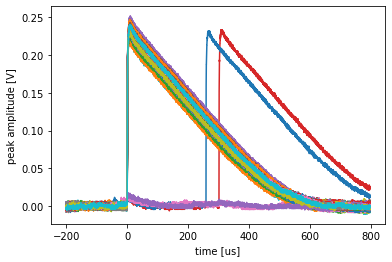

In [14]:
for i in range(len(plot_array)):
    plt.plot(time_axis*1e6, plot_array[i])
    
plt.xlabel('time [us]')
plt.ylabel('peak amplitude [V]')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_traces.png')
    

### This function will extract the peak from each trace/row of the data set. The noise sample is determined by eye; pick a range of x values where there don't appear to be (many) peaks, ex. from 2000:3500.

In [15]:
peaks = f[dsName + '_peaks' ]
integ = f[dsName + "_integral"]

### Plot a histogram of the peaks using matplotlib to get a sense of what the data looks like and where the peak is.

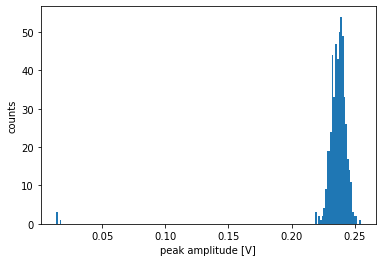

In [16]:
#ultra fine binning for debugging input
plt.hist(peaks, bins=180)
plt.xlabel('peak amplitude [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_runtimePeakHist.png')


# Do the same for the trace integral

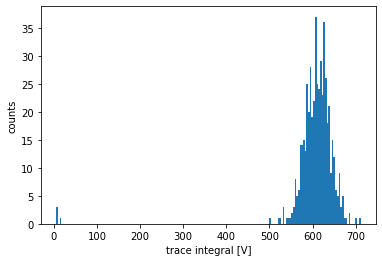

In [17]:
#ultra fine binning for debugging input
plt.hist(integ, bins=180)
plt.xlabel('trace integral [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_runtimeIntegHist.png')

### If you are done working with a file, ***make sure you close it!*** h5py does not like it when files are left open and you change files and/or kill the kernel.

In [18]:
f.close()

YOU DID IT!!!